In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Dropout
from keras.layers import Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import keras

Using TensorFlow backend.


In [2]:
EPOCH = 5
BATCH_SIZE = 5
ITERATIONS = 1
LSTM_UNITS = 20
LEARNING_RATE = 0.00005
FEATURES_COUNT = 11
TIME_STEPS = 5
DATA_LENGTH = 1500
SUBJECT = "부광약품"

def normalize_dataframe(df):
    #scaler = MinMaxScaler(feature_range=(-5,5))
    for column in df:
        #if column == 'Diff':
        #    continue
        window = df[column].values.reshape(-1, 1)
        min_v = min(window)
        normalized_window = np.array([((float(p) / float(min_v)) - 1) for p in window]).reshape(len(df), 1)
        #scaler.fit(window)
        #normalized_window = scaler.transform(window)
        df[column] = normalized_window
    return df

def denormalize(arr):
    arr = np.array(arr).reshape(1,-1)
    scaler = MinMaxScaler(feature_range=(0, 10))
    scaler.fit(arr)
    denormalized = scaler.inverse_transform(arr)
    return denormalized

def diff_to_percent(stock):
    res = []
    diff = stock['Diff'].values.reshape(-1,1)
    close = stock['Close'].values.reshape(-1,1)
    for i in range(len(diff)):
        if i == 0:
            res.append([0])
            continue
        res.append((close[i]-close[i-1])/close[i-1] *100)
    res = np.array(res)
    return res.flatten()

def create_dataset(data):
    dataY = []
    dataX = []
    for i in range(len(data)-TIME_STEPS):
        dataX.append(data[i:(i+TIME_STEPS), :FEATURES_COUNT])
        dataY.append(data[i + TIME_STEPS, -1]) # loc of Diff
    return np.array(dataX), np.array(dataY)

def adjust_index(small, big, col_idx, num):
    big.index = [ a[:7] for a in big.index]

    for c in small.columns:
        big[c]= small[c]

    for i, s in enumerate(small.index):
        if i == 0:
            start = 0
        df_small = small.loc[s].to_frame().T
        num = len([b for b in big.index if b == s])
        big.iloc[start:start+num, col_idx:col_idx+num+1] = df_small
        start += num
    return big

def remove_str_from_row(string, row, cols):
    for col in cols:
        row[col] = float(row[col].replace(string, ''))
    return row

stock = pd.read_csv('./stock/{s}/{s}.csv'.format(s=SUBJECT))
stock.columns = ['Date', 'Close','Open', 'High', 'Low', 'Volume', 'IndividualBuying','ForeignerBuying','InstitutionBuying', 'ForeignerHolding', 'InstitutionHolding', 'Diff','Change' ]
stock = stock.set_index('Date').dropna()
stock['Diff'] = [d[-2] * -1 if d[-1] == 'FALL' or d[-1] == 'LOWER_LIMIT' else d[-2] for d in stock.values ]
stock = stock.drop(['Change'], axis=1)
stock = stock.sort_index()
stock['Diff'] = diff_to_percent(stock)

In [3]:
#stock = normalize_dataframe(stock)
#interest = pd.read_csv('interest_rate.csv').T
#exchange = pd.read_csv('exchagne.csv').T

#interest.columns = ['3yr', '5yr', '10yr', '3yrDebenture', 'CD', 'Call', 'BenchInterest' ]
#interest = interest.drop(['Unnamed: 0'])
#interest.index = ['{y}-{m}'.format(y=d[:4], m=d[4:6]).strip() for d in interest.index]
#interest = normalize_dataframe(interest)

#exchange = exchange.dropna(axis=1)
#exchange.columns = ['w2d', 'y2d', 'w2y']
#exchange = exchange.drop(['Unnamed: 0'])
#ex_rows = [remove_str_from_row(',', row, exchange.columns) for i, row in exchange.iterrows()]
#exchange = pd.DataFrame(ex_rows, columns=['w2d','y2d', 'w2y'])
#exchange.index =  ['{y}-{m}'.format(y=d[:4], m=d[4:6]).strip() for d in exchange.index]
#exchange = normalize_dataframe(exchange)

#tmp_idx = stock.index
#stock = adjust_index(interest, stock, len(stock.columns), len(interest.columns))
#stock = adjust_index(exchange, stock, len(stock.columns), len(exchange.columns))

In [4]:
stock = stock[['Diff','Open','High','Low','Volume', 'IndividualBuying', 'ForeignerBuying', 'InstitutionBuying', 'ForeignerHolding', 'InstitutionHolding','Close']]
stock = normalize_dataframe(stock)
stock = stock.fillna(method='ffill')
#stock.index = tmp_idx


In [5]:

train = stock[0:1000]
val = stock[1000:1250]
test = stock[1250:]

In [6]:
# In[7]:


x_train, y_train = create_dataset(train.to_numpy())
x_val, y_val = create_dataset(val.to_numpy())
x_test, y_test = create_dataset(test.to_numpy())


# In[8]:


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], FEATURES_COUNT))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], FEATURES_COUNT))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], FEATURES_COUNT))


# In[9]:
model = Sequential()
model.add(LSTM(64,
            batch_input_shape=(BATCH_SIZE, TIME_STEPS, FEATURES_COUNT),
            return_sequences = True
        ))
model.add(Dropout(0.4))
for i in range(1):
    model.add(LSTM(64, batch_input_shape=(BATCH_SIZE, TIME_STEPS, FEATURES_COUNT)))
    model.add(Dropout(0.4))
model.add(Dense(1))

# 3. 모델 구성하기  batch_input_shape=(1, TIME_STEPS, FEATURES_COUNT)
adam = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss = 'mean_squared_error', optimizer = adam, metrics= ['accuracy'])

#model = Sequential()
#for i in range(2):
#    model.add(LSTM(32, batch_input_shape=(1, TIME_STEPS, FEATURES_COUNT), stateful=True, return_sequences=True))
#    model.add(Dropout(0.3))
#model.add(LSTM(32, batch_input_shape=(1, TIME_STEPS, FEATURES_COUNT), stateful=True))
#model.add(Dropout(0.3))
#model.add(Dense(1))


#model.compile(loss='mean_squared_error', optimizer="rmsprop", metrics= ['accuracy'])


In [7]:
# 5. 모델 학습시키기
for epoch_idx in range(ITERATIONS):
    print('epochs : ' + str(epoch_idx) + ' / '+str(ITERATIONS) )
    model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=False, validation_data=(x_val, y_val)) # 50 is X.shape[0]
    model.reset_states()

model.save_weights("./stock/{s}/{s}_weight".format(s=SUBJECT))
model_json = model.to_json()
with open("./stock/{s}/{s}_model".format(s=SUBJECT), "w") as json_file:
    json_file.write(model_json)
    print('Model JSON File is saved!')

epochs : 0 / 1
Train on 995 samples, validate on 245 samples
Epoch 1/5
995/995 [==============================] - 1s 1ms/step - loss: 0.3707 - accuracy: 0.0030 - val_loss: 0.0816 - val_accuracy: 0.0041

ts5ep5it1.png


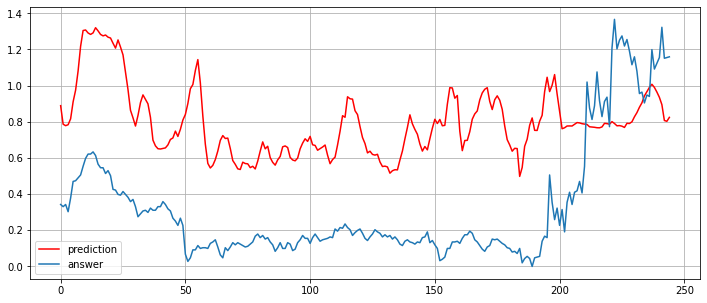

In [8]:
pred = model.predict(x_test, batch_size=BATCH_SIZE)

#r = []
#for i, p in enumerate(pred.reshape(1,-1)[0]):
#    r.append([int(np.sign(p) == np.sign(y_test[i]))])
#r = list(np.array(r).reshape(1,-1)[0])
#acc = r.count(1)/ len(r) * 100

plt.figure(figsize=(12, 5))
plt.plot(pred, 'r', label="prediction")
plt.plot(y_test, label="answer")
plt.grid(b=True, which='both', axis='both')
plt.legend()
plt.savefig('./stock/{3}/ts{0}ep{1}it{2}.png'.format(TIME_STEPS, EPOCH, ITERATIONS, SUBJECT))
print("ts{0}ep{1}it{2}.png".format(TIME_STEPS, EPOCH, ITERATIONS, SUBJECT))